# Global warming impact on Tip-Jet frequency and intensity


In this notebook, we're looking at how frequency and intensity of Tip-Jet events might change in southern Greenland under different future scenarios: SSP126 (forcing of 8.5 W/m² by 2100) and SSP585 (forcing of 2.6 W/m² by 2100).

In [ ]:
# Install some libraries in Colab
!pip install zarr
!pip install gcsfs
!pip uninstall -y shapely
!pip install shapely==1.8.5 --no-binary shapely
!pip install cartopy
!pip install netCDF4

Found existing installation: Shapely 1.8.5
Uninstalling Shapely-1.8.5:
  Successfully uninstalled Shapely-1.8.5
  Using cached Shapely-1.8.5-cp310-cp310-linux_x86_64.whl
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.


In [ ]:
from tip_jet_detection import Ensemble
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import gcsfs
from scipy.stats import norm
import cartopy.crs as ccrs

## Annual number of Tip-Jets for different scenarios:

In this part, we'll look at how the yearly count of Tip-Jet events might change for two different scenarios:

- **SSP126 (Low Emission)**

- **SSP585 (High Emission)**

In [ ]:
# extracting available data for SSP126 and SSP585 scenarios
df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
df_members_ssp126 = df.query(
            f"activity_id=='ScenarioMIP' & table_id=='day' & experiment_id=='ssp126' & variable_id=='uas' & source_id=='IPSL-CM6A-LR'")
df_members_ssp585 = df.query(
            f"activity_id=='ScenarioMIP' & table_id=='day' & experiment_id=='ssp585' & variable_id=='uas' & source_id=='IPSL-CM6A-LR'")

In [ ]:
df_members_ssp126

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
73097,ScenarioMIP,IPSL,IPSL-CM6A-LR,ssp126,r3i1p1f1,day,uas,gr,gs://cmip6/CMIP6/ScenarioMIP/IPSL/IPSL-CM6A-LR...,NaN,20190410
74835,ScenarioMIP,IPSL,IPSL-CM6A-LR,ssp126,r2i1p1f1,day,uas,gr,gs://cmip6/CMIP6/ScenarioMIP/IPSL/IPSL-CM6A-LR...,NaN,20190410
279448,ScenarioMIP,IPSL,IPSL-CM6A-LR,ssp126,r1i1p1f1,day,uas,gr,gs://cmip6/CMIP6/ScenarioMIP/IPSL/IPSL-CM6A-LR...,NaN,20190903
386712,ScenarioMIP,IPSL,IPSL-CM6A-LR,ssp126,r14i1p1f1,day,uas,gr,gs://cmip6/CMIP6/ScenarioMIP/IPSL/IPSL-CM6A-LR...,NaN,20191121
387623,ScenarioMIP,IPSL,IPSL-CM6A-LR,ssp126,r6i1p1f1,day,uas,gr,gs://cmip6/CMIP6/ScenarioMIP/IPSL/IPSL-CM6A-LR...,NaN,20191121
387812,ScenarioMIP,IPSL,IPSL-CM6A-LR,ssp126,r4i1p1f1,day,uas,gr,gs://cmip6/CMIP6/ScenarioMIP/IPSL/IPSL-CM6A-LR...,NaN,20191121


In [ ]:
df_members_ssp585

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
279146,ScenarioMIP,IPSL,IPSL-CM6A-LR,ssp585,r1i1p1f1,day,uas,gr,gs://cmip6/CMIP6/ScenarioMIP/IPSL/IPSL-CM6A-LR...,NaN,20190903
386855,ScenarioMIP,IPSL,IPSL-CM6A-LR,ssp585,r3i1p1f1,day,uas,gr,gs://cmip6/CMIP6/ScenarioMIP/IPSL/IPSL-CM6A-LR...,NaN,20191121
387094,ScenarioMIP,IPSL,IPSL-CM6A-LR,ssp585,r2i1p1f1,day,uas,gr,gs://cmip6/CMIP6/ScenarioMIP/IPSL/IPSL-CM6A-LR...,NaN,20191121
388545,ScenarioMIP,IPSL,IPSL-CM6A-LR,ssp585,r14i1p1f1,day,uas,gr,gs://cmip6/CMIP6/ScenarioMIP/IPSL/IPSL-CM6A-LR...,NaN,20191121
390365,ScenarioMIP,IPSL,IPSL-CM6A-LR,ssp585,r4i1p1f1,day,uas,gr,gs://cmip6/CMIP6/ScenarioMIP/IPSL/IPSL-CM6A-LR...,NaN,20191122


In climate simulations, "member_id" is a special ID for different runs or versions of a climate model. Scientists use these IDs because they run the model many times with slightly different starting conditions or settings. This variety of runs helps to understand the range of possibilities and uncertainties in the model's predictions.<br>We have 6 members for SSP126 and 5 members for SSP585. We will gather data from all those members to reduce the uncertainty for a given scenario.

In [ ]:
# initialising the different members of scenrio ssp126
ens_126 = Ensemble(list_of_member = ['r1i1p1f1','r2i1p1f1','r3i1p1f1','r4i1p1f1','r6i1p1f1','r14i1p1f1'], experiment='ssp126' )
ens_585 = Ensemble(list_of_member = ['r1i1p1f1','r2i1p1f1','r3i1p1f1','r4i1p1f1','r14i1p1f1'], experiment='ssp585' )

In [ ]:
# get the annual number of Tip-Jet averaged by all members and standard deviation
annual_mean_ssp126, annual_std_ssp126 = ens_126.mean_annual_events_ensemble()
annual_mean_ssp585, annual_std_ssp585 = ens_585.mean_annual_events_ensemble()

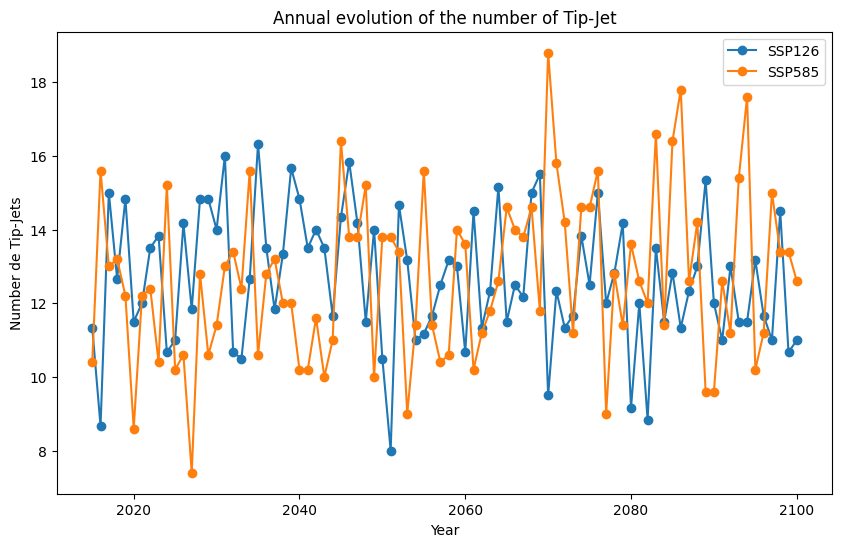

In [ ]:
years = np.arange(2015, 2101)

plt.figure(figsize=(10, 6))
plt.plot(years, annual_mean_ssp126, label='SSP126', marker='o')
plt.plot(years, annual_mean_ssp585, label='SSP585', marker='o')
plt.title('Annual evolution of the number of Tip-Jet')
plt.xlabel('Year')
plt.ylabel('Number de Tip-Jets')
plt.legend()

# Affichage du graphique
plt.show()

From the graph above, we observe that there isn't a significant different behaviour between the two scenarios in the annual number of Tip-Jets. For some years, the number of Tip-Jets for the scenario SSP126 is higher than the scenario SSP585, but in other years, it's the opposite. <br>
To try to spot the difference between the two scenarios, we'll use a moving average. Multiple window sizes have been experimented to obtain the most comprehensive visualization.

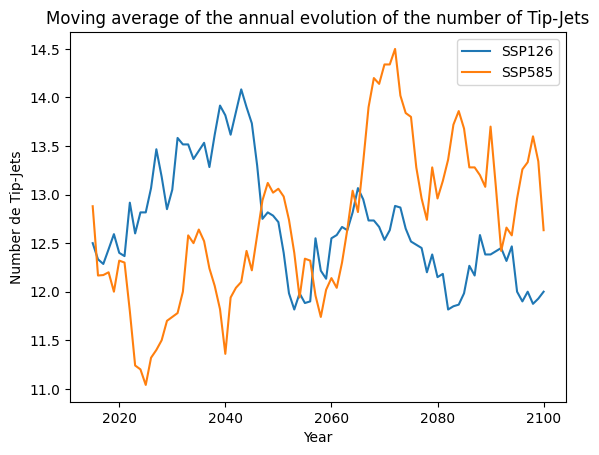

In [ ]:
window_size = 10
annual_mean_ssp126_df = pd.Series(annual_mean_ssp126)
annual_mean_ssp126_rolled = annual_mean_ssp126_df.rolling(window=window_size, min_periods=5, center=True).mean()
annual_mean_ssp585_df = pd.Series(annual_mean_ssp585)
annual_mean_ssp585_rolled = annual_mean_ssp585_df.rolling(window=window_size, min_periods=5, center=True).mean()

plt.plot(np.arange(2015, 2101), annual_mean_ssp126_rolled, label='SSP126')
plt.plot(np.arange(2015, 2101), annual_mean_ssp585_rolled, label='SSP585')
plt.legend()
plt.xlabel('Year')
plt.ylabel('Number de Tip-Jets')
plt.title('Moving average of the annual evolution of the number of Tip-Jets')
plt.show()

In the first years, the average number of Tip-Jet occurrences for scenario SSP585 is lower than that for scenario SSP126. However, from the years 2065 to 2100, the average number of Tip-Jet events for scenario SSP585 significantly surpasses that of scenario SSP126. Consequently, it can be inferred that global warming may contribute to an increase in the average number of Tip-Jets in Greenland.<br><br>
Now, we will examine the mean number of Tip-Jets for the farthest years, considering a confidence interval of 95%.

In [ ]:
print("Mean number of Tip-Jets for the year 2080 to 2100 on the scenario SSP126 = "
      + str(round(np.mean(annual_mean_ssp126[-21:]), 2)) +
      " ; Confidence interval at 95% =[" + str(round(np.mean(annual_mean_ssp126[-21:]) -
       norm.ppf(0.975) * (np.mean(annual_std_ssp126[-21:])) / np.sqrt(21), 2)) + "; "
      + str(round(np.mean(annual_mean_ssp126[-21:]) + norm.ppf(0.975) *
        (np.mean(annual_std_ssp126[-21:])) / np.sqrt(21), 2)) + "]")

Mean number of Tip-Jets for the year 2080 to 2100 on the scenario SSP126 = 11.94 ; Confidence interval at 95% =[10.29; 13.6]


In [ ]:
print("Mean number of Tip-Jets for the year 2080 to 2100 on the scenario SSP585 = "
      + str(round(np.mean(annual_mean_ssp585[-21:]), 2)) +
      " ; Confidence interval at 95% =[" + str(round(np.mean(annual_mean_ssp585[-21:]) -
       norm.ppf(0.975) * (np.mean(annual_std_ssp585[-21:])) / np.sqrt(21), 2)) + "; "
      + str(round(np.mean(annual_mean_ssp585[-21:]) + norm.ppf(0.975) *
        (np.mean(annual_std_ssp585[-21:])) / np.sqrt(21), 2)) + "]")

Mean number of Tip-Jets for the year 2080 to 2100 on the scenario SSP585 = 13.29 ; Confidence interval at 95% =[11.46; 15.11]


The confidence intervals overlap, so we cannot conclusively state that the number of Tip-Jet occurrences will be higher in SSP585 scenario. Nevertheless, it seems more likely that an increase is anticipated.

## Wind speed under Tip-Jet events in different scenarios :

As done before, we will focus on the farthest years from 2080 to 2100 and see if there's is a difference in the wind intensity for the two scenarios.

In [ ]:
ens_126_wind_intensity = ens_126.tip_jet_wind_intensity_ensemble(pd.to_datetime('2080-01-01'),pd.to_datetime('2101-01-01'))
ens_585_wind_intensity = ens_585.tip_jet_wind_intensity_ensemble(pd.to_datetime('2080-01-01'),pd.to_datetime('2101-01-01'))

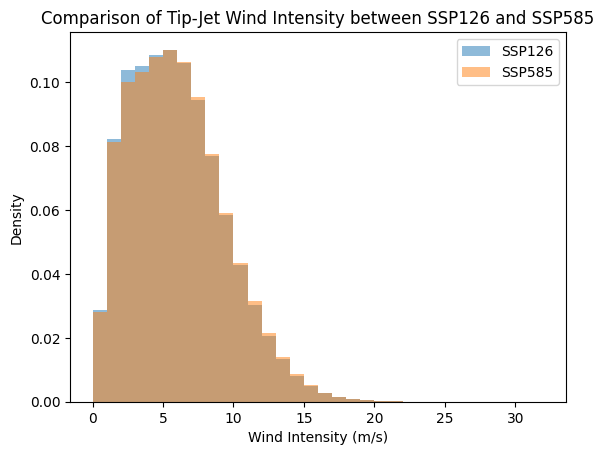

In [ ]:
plt.hist(ens_126_wind_intensity, bins=range(0, int(np.max(ens_126_wind_intensity)) + 1), density=True, alpha=0.5, label='SSP126')
plt.hist(ens_585_wind_intensity, bins=range(0, int(np.max(ens_585_wind_intensity)) + 1), density=True, alpha=0.5, label='SSP585')
plt.xlabel('Wind Intensity (m/s)')
plt.ylabel('Density')
plt.title('Comparison of Tip-Jet Wind speed between SSP126 and SSP585')
plt.legend()
plt.show()

We notice that the wind speed during Tip-Jet events hardly varies based on the two scenarios. Bellow we observe that the mean wind speed ar

In [ ]:
print("Mean wind speed during Tip-Jet events for the years 2080 to 2100 in the scenario SSP126 = " +
      str(round(np.mean(ens_126_wind_intensity), 2)) +
      " m/s ; Confidence interval at 95% =[" + str(round(np.mean(ens_126_wind_intensity) -
       norm.ppf(0.975) * (np.std(ens_126_wind_intensity)) / np.sqrt(2101-2015), 2)) + " ; " +
      str(round(np.mean(ens_126_wind_intensity) + norm.ppf(0.975) * (np.std(ens_126_wind_intensity)) / np.sqrt(2101-2015), 2)) + "]")

Mean wind intensity during Tip-Jet events for the years 2080 to 2100 in the scenario SSP126 = 5.99 m/s ; Confidence interval at 95% =[5.28 ; 6.7]


In [ ]:
print("Mean wind speed during Tip-Jet events for the years 2080 to 2100 in the scenario SSP585 = " +
      str(round(np.mean(ens_585_wind_intensity), 2)) +
      " m/s ; Confidence interval at 95% =[" + str(round(np.mean(ens_585_wind_intensity) -
       norm.ppf(0.975) * (np.std(ens_585_wind_intensity)) / np.sqrt(2101-2015), 2)) + " ; " +
      str(round(np.mean(ens_585_wind_intensity) + norm.ppf(0.975) * (np.std(ens_585_wind_intensity)) / np.sqrt(2101-2015), 2)) + "]")

Mean wind intensity during Tip-Jet events for the years 2080 to 2100 in the scenario SSP585 = 6.06 m/s ; Confidence interval at 95% =[5.34 ; 6.77]


Now, let's determine if the difference in wind speed is visible on the map of Greenland. We will display the average wind speed during Tip-jet events for both scenarios.

In [ ]:
ens_126_tip_jet_map = ens_126.visualize_tip_jet_on_map_ensemble(pd.to_datetime('2079-12-31'),pd.to_datetime('2101-01-01'))
ens_585_tip_jet_map = ens_585.visualize_tip_jet_on_map_ensemble(pd.to_datetime('2079-12-31'),pd.to_datetime('2101-01-01'))

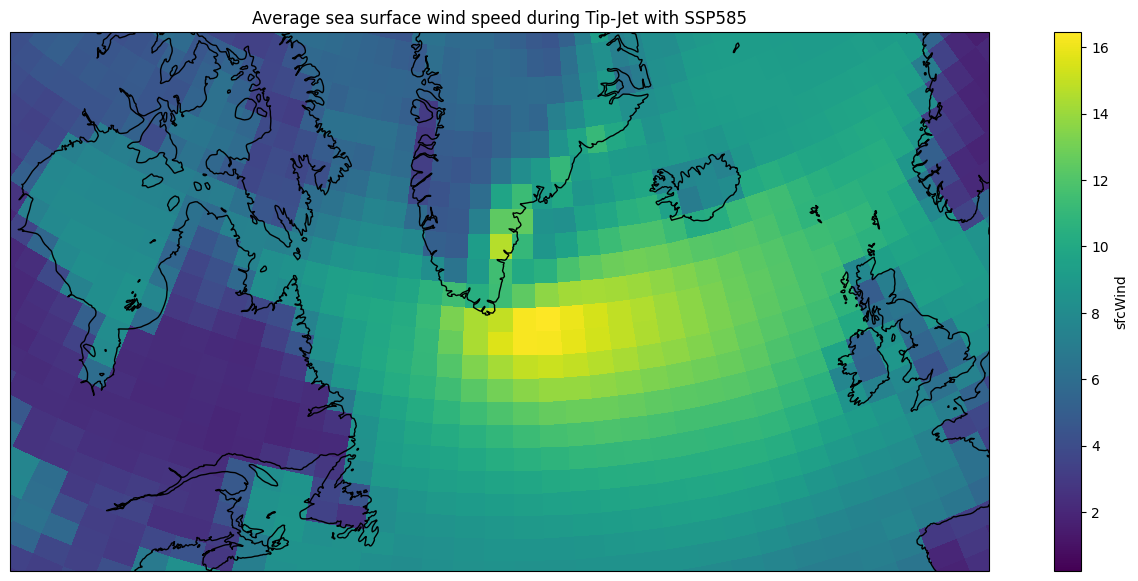

In [ ]:
all_wind_ssp585_by_members = xr.concat(list(ens_585_tip_jet_map.values()), dim='member')
average_wind_ssp585_by_members = all_wind_ssp585_by_members.mean(dim='member')
plt.figure(figsize=(17,7))
ax = plt.axes(projection=ccrs.LambertConformal(-42, 60))
average_wind_ssp585_by_members.plot(ax=ax, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_extent([-80, -5, 40, 70])
ax.set_title('Average sea surface wind speed during Tip-Jet with SSP585')
plt.show()

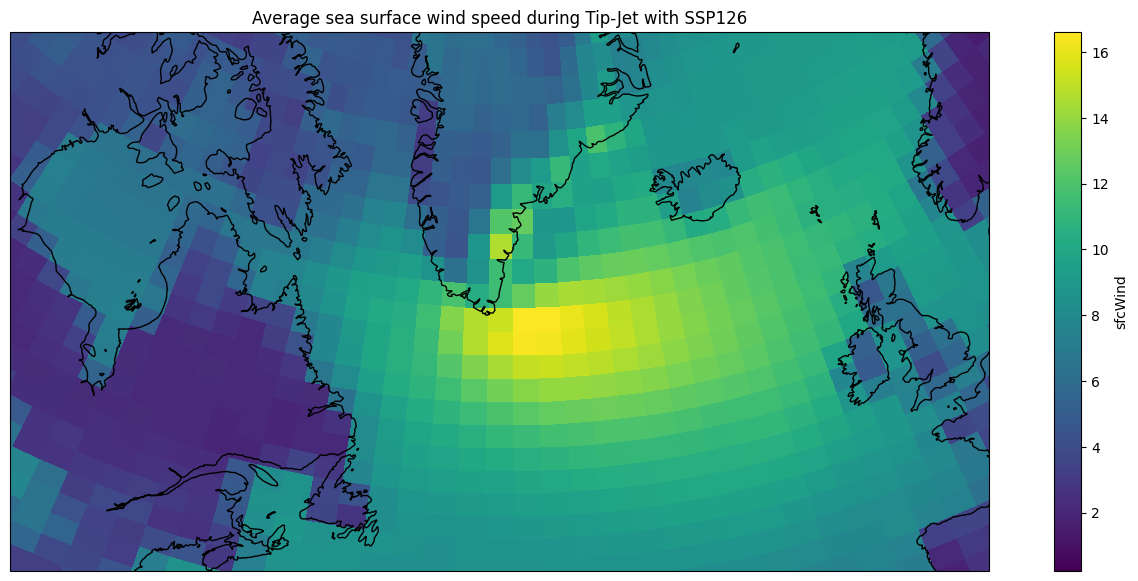

In [ ]:
all_wind_ssp126_by_members = xr.concat(list(ens_126_tip_jet_map.values()), dim='member')
average_wind_ssp126_by_members = all_wind_ssp126_by_members.mean(dim='member')
plt.figure(figsize=(17,7))
ax = plt.axes(projection=ccrs.LambertConformal(-42, 60))
average_wind_ssp126_by_members.plot(ax=ax, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_extent([-80, -5, 40, 70])
ax.set_title('Average sea surface wind speed during Tip-Jet with SSP126')
plt.show()

Both maps look very similar, with no significant differences in wind intensity between the two scenarios. To confirm, let's examine the differences in wind intensities between the two scenarios on the map.

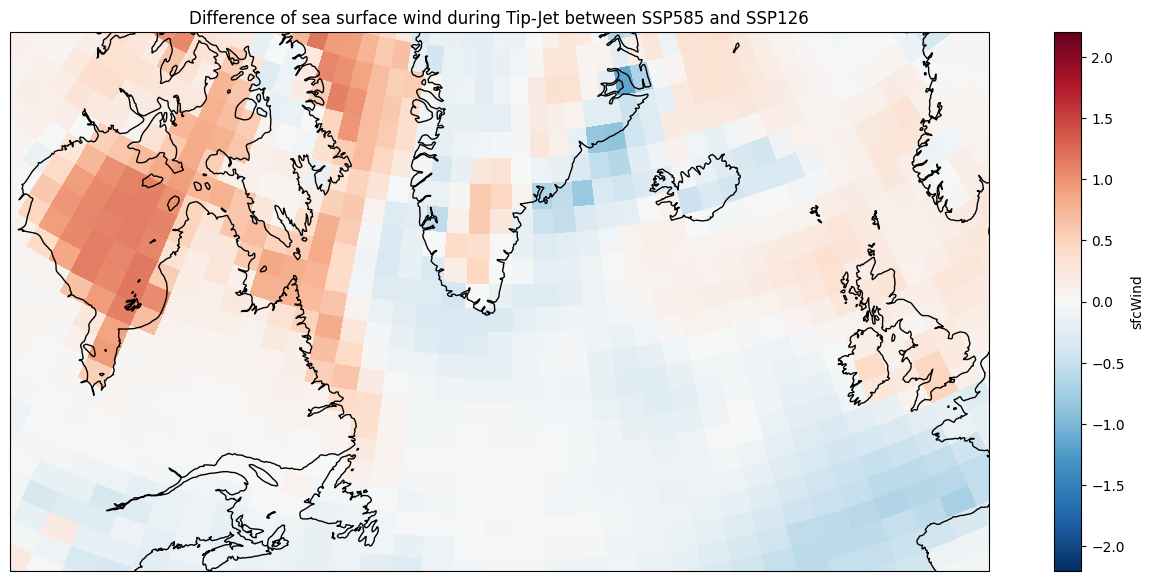

In [ ]:
difference_senarios_585_126 =  average_wind_ssp585_by_members - average_wind_ssp126_by_members

plt.figure(figsize=(17,7))
ax = plt.axes(projection=ccrs.LambertConformal(-42, 60))
difference_senarios_585_126.plot(ax=ax, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_extent([-80, -5, 40, 70])
ax.set_title('Difference of sea surface wind during Tip-Jet between SSP585 and SSP126')
plt.show()

From the map above, we cannot discern a significant difference in wind intensity between the two scenarios in the south of Greenland.